In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from scipy.stats import chi2
import Regression

In [2]:
telco = pd.read_excel('Telco-Customer-Churn.xlsx')
telco.head()

,CustomerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0002-ORFBO,Female,No,Yes,Yes,9,Yes,No,DSL,No,...,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30,No
1,0003-MKNFE,Male,No,No,No,9,Yes,Yes,DSL,No,...,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40,No
2,0004-TLHLJ,Male,No,No,No,4,Yes,No,Fiber optic,No,...,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85,Yes
3,0011-IGKFF,Male,Yes,Yes,No,13,Yes,No,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85,Yes
4,0013-EXCHZ,Female,Yes,Yes,No,3,Yes,No,Fiber optic,No,...,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40,Yes


In [3]:
telco.describe()

,Tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7032.000000
mean,32.371149,64.761692,2283.300441
std,24.559481,30.090047,2266.771362
min,0.000000,18.250000,18.800000
25%,9.000000,35.500000,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.850000,3794.737500
max,72.000000,118.750000,8684.800000


## QUESTION 1

### Before you train the model, you will first understand how the predictors individually affect the churn.

#### (a)  For each categorical predictor,
<b>  • Generate a vertical bar chart that shows the odds of Churn for each category.<br>
<b>  • Display the categories in the order of descending odds of Churn.<br>
<b>  • Add a reference line to indicate the overall odds of Churn.<br>
<b>  • Comment on whether it may affect the target variable.

In [4]:
target_original = 'Churn'
cat_pred = ['Contract', 'Dependents', 'Gender', 'InternetService', 'MultipleLines', 'PaperlessBilling',
            'Partner', 'PhoneService', 'SeniorCitizen']
int_pred = ['MonthlyCharges', 'Tenure', 'TotalCharges']
trainData = telco[[target_original] + cat_pred + int_pred] # Only necessary variables
trainData = trainData.dropna().reset_index()                       # Remove missing values
trainData.head()

,index,Churn,Contract,Dependents,Gender,InternetService,MultipleLines,PaperlessBilling,Partner,PhoneService,SeniorCitizen,MonthlyCharges,Tenure,TotalCharges
0,0,No,One year,Yes,Female,DSL,No,Yes,Yes,Yes,No,65.6,9,593.30
1,1,No,Month-to-month,No,Male,DSL,Yes,No,No,Yes,No,59.9,9,542.40
2,2,Yes,Month-to-month,No,Male,Fiber optic,No,Yes,No,Yes,No,73.9,4,280.85
3,3,Yes,Month-to-month,No,Male,Fiber optic,No,Yes,Yes,Yes,Yes,98.0,13,1237.85
4,4,Yes,Month-to-month,No,Female,Fiber optic,No,Yes,Yes,Yes,Yes,83.9,3,267.40


In [5]:
print(trainData.isnull().sum())

index               0
Churn               0
Contract            0
Dependents          0
Gender              0
InternetService     0
MultipleLines       0
PaperlessBilling    0
Partner             0
PhoneService        0
SeniorCitizen       0
MonthlyCharges      0
Tenure              0
TotalCharges        0
dtype: int64


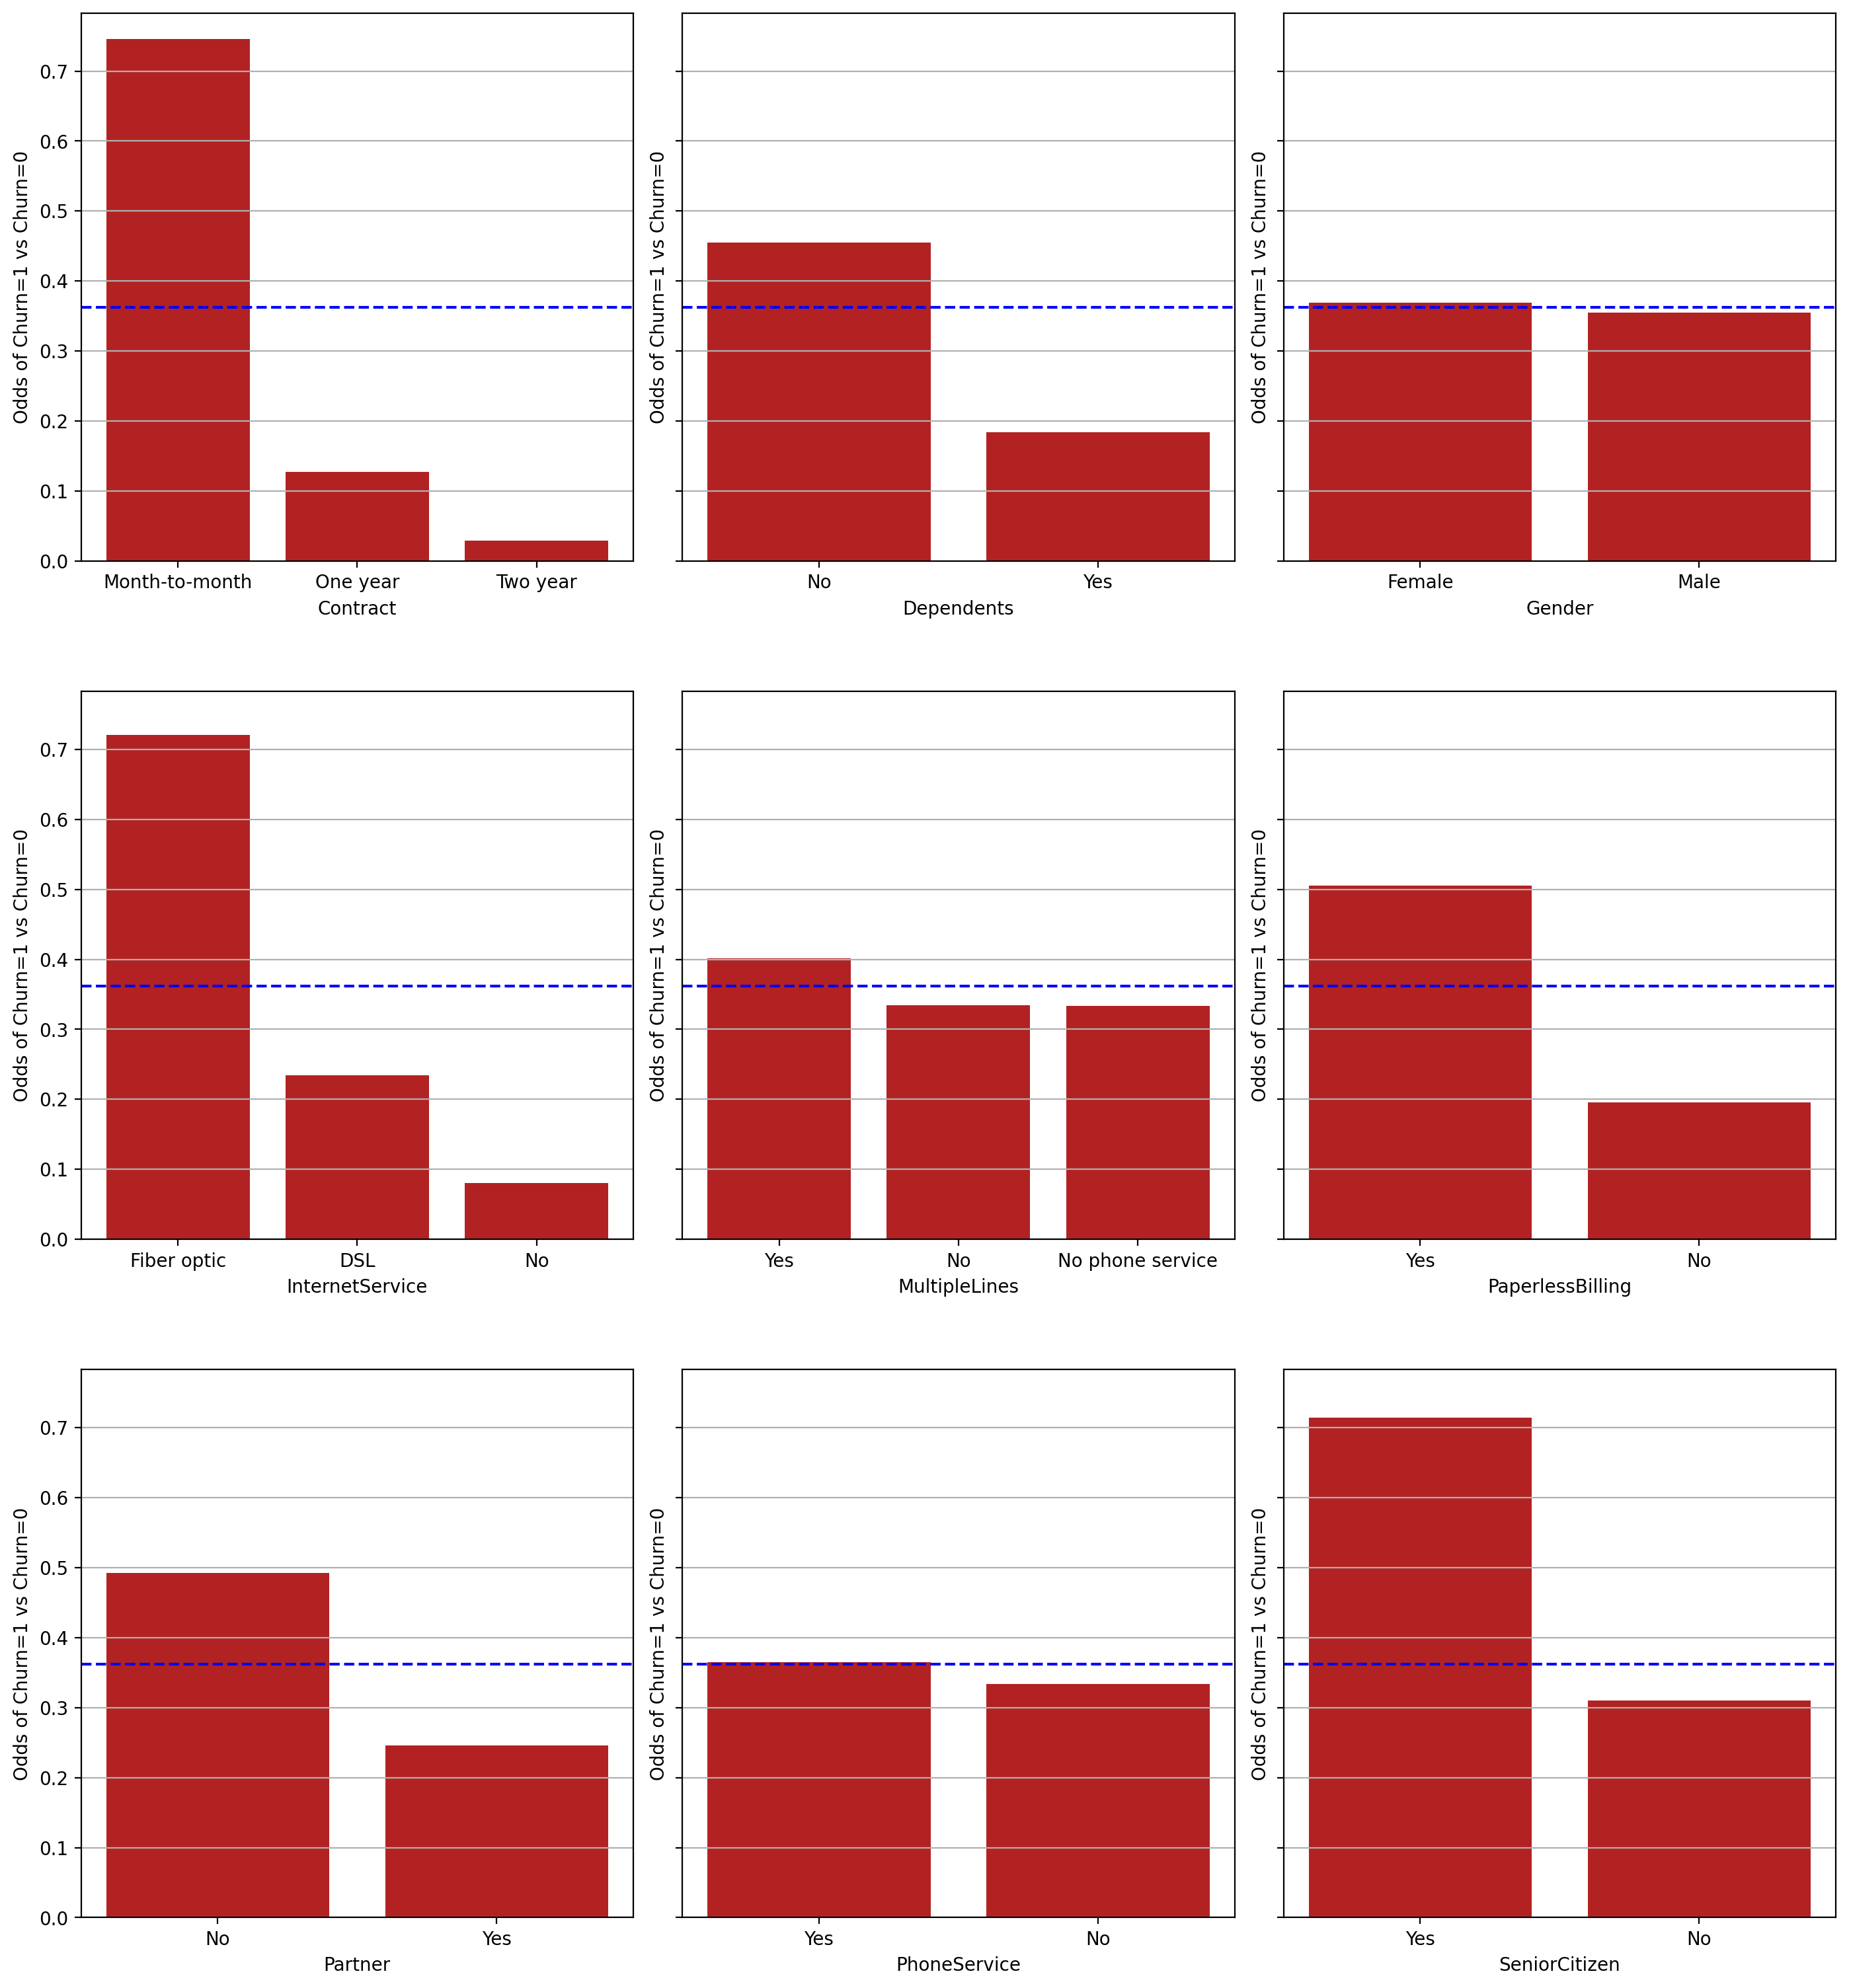

In [6]:
# Calculate the overall odds
yFreq = trainData.groupby('Churn').size()
overall_odds = yFreq[1] / yFreq[0]

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(nrows = 3, ncols = 3, dpi = 200, sharey = True, 
                                                                  figsize = (14,15))
fig.tight_layout(h_pad = 5)

ax_list = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]
for x, ax in zip(cat_pred, ax_list):
    xtab = pd.crosstab(index = trainData[x], columns = trainData['Churn'])
    xtab.reset_index(inplace = True)
    xtab['N'] = xtab['No'] + xtab['Yes']
    xtab['Odds'] = xtab['Yes'] / xtab['No']
    xtab.sort_values(by = 'Odds', ascending = False, inplace = True)

    ax.bar(xtab[x], xtab['Odds'], color = 'firebrick')
    ax.axhline(y = overall_odds, color = 'blue', linestyle = '--', label = 'Overall Odds')
    ax.set_xlabel(x)
    ax.set_ylabel('Odds of Churn=1 vs Churn=0')
    ax.set_xticks(xtab[x])
    ax.grid(axis ='y')


As Contract, Internet Service and SeniorCitizen have categories much higher than the average and will be assumed to have a high impact on the target variable.
Whereas Dependents, MultipleLines and Partner have some categories somewhat above the average so it may have a smaller impact on the target.
I believe Gender and PhoneService will have no impact on the target variable.

#### (b) For each interval predictor,
<b>• Generate a horizontal boxplot grouped by the target categories.<br>
<b>• Add a reference line to indicate the overall mean of the interval predictor.<br>
<b>• Comment on whether it may affect the target variable.

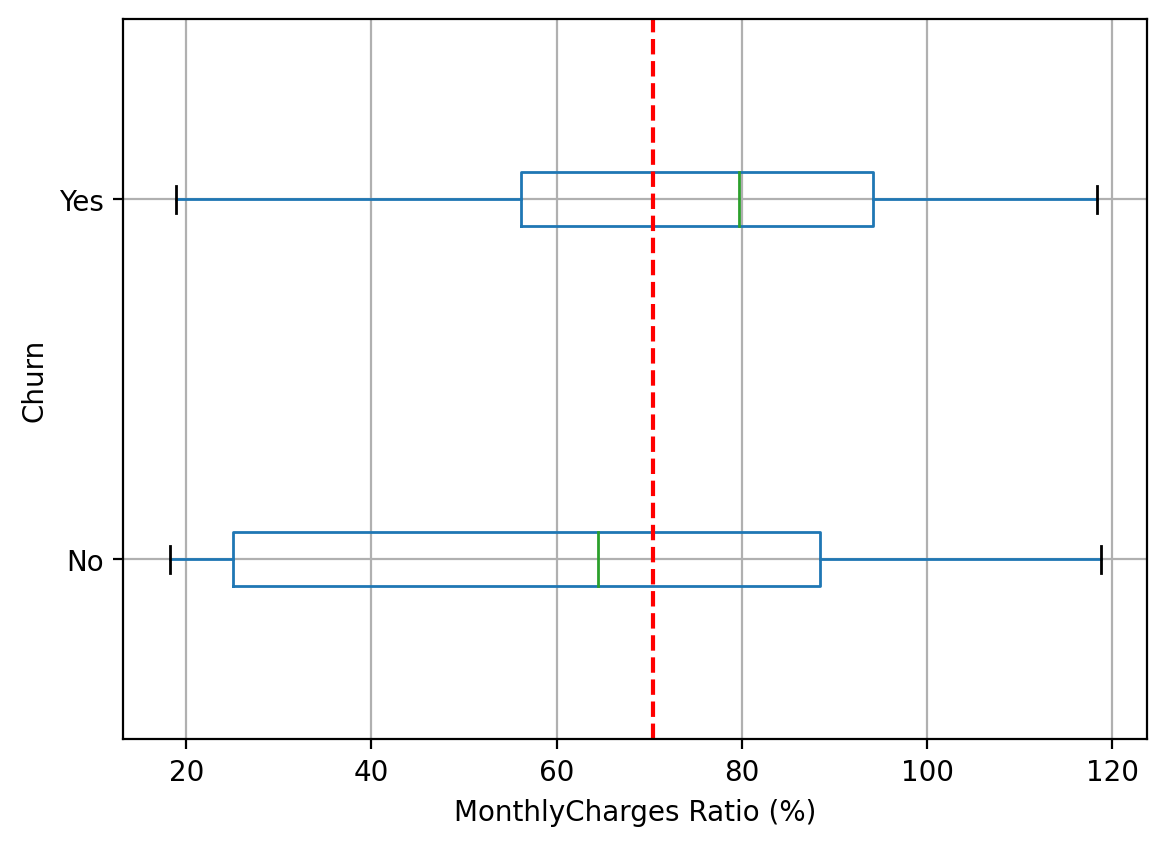

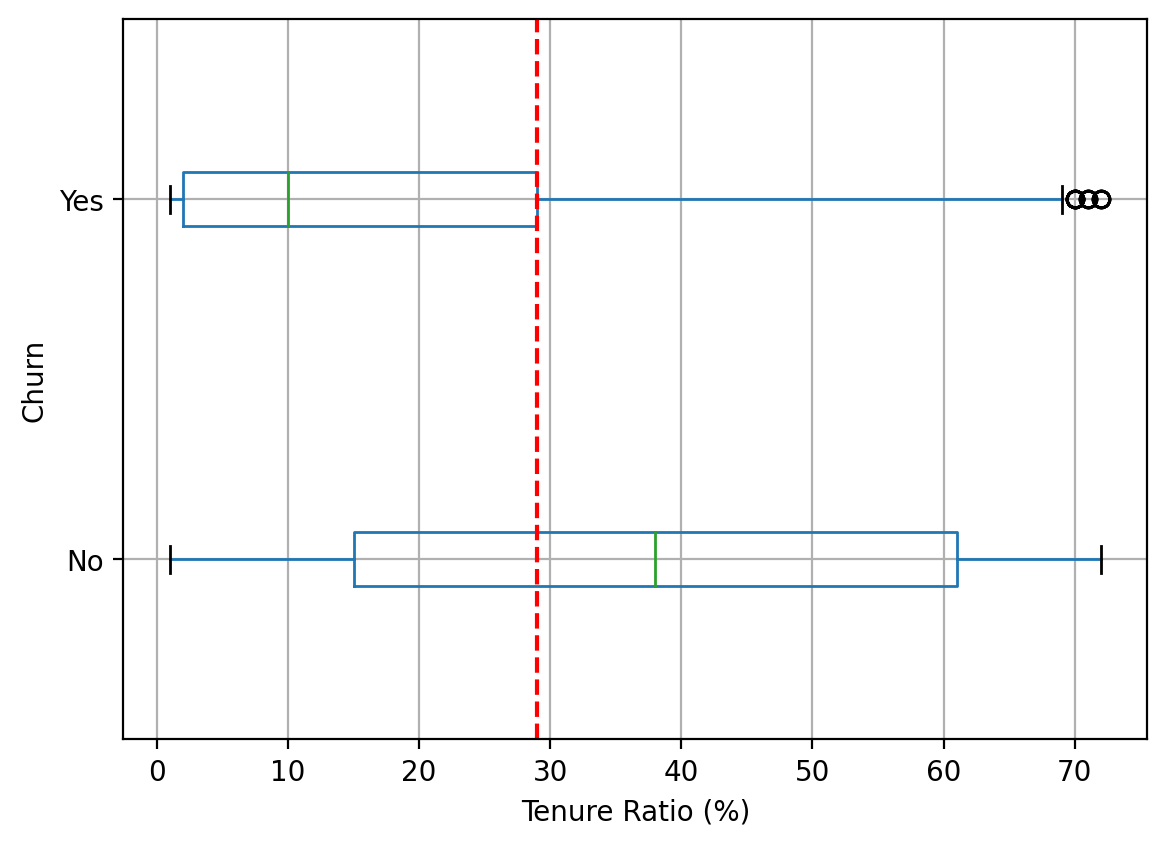

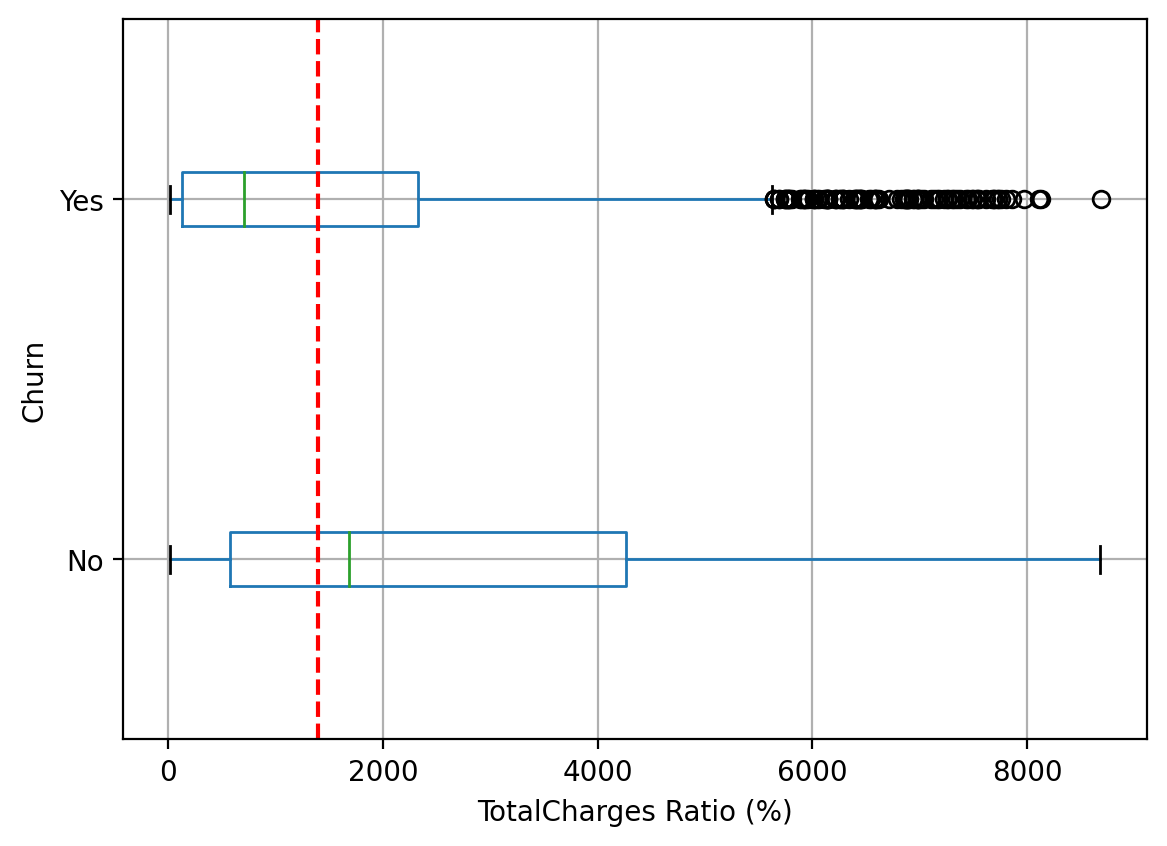

In [7]:
for x in int_pred:
    fig, ax = plt.subplots(nrows = 1, ncols = 1, dpi = 200)
    predMedian = np.median(trainData[x])
    trainData.boxplot(column=x, by = 'Churn', vert = False, ax = ax)
    ax.axvline(x = predMedian, color = 'red', linestyle = '--', label = 'Overall Mean')
    ax.set_xlabel(x + " Ratio (%)")
    ax.set_ylabel("Churn")
    ax.yaxis.grid(True)
    plt.suptitle("")
    plt.title("")
    plt.show()

MonthlyCharges ratio has events occuring both slightly above and below average and will not have much impact on the target. Whereas, Tenure has a high chance of affecting the target because it's events (No) are higher than average even thoug it has outliers. TotalCharges on the other hand will have a medium impact on the target as it's events are slightly above average but it has many outliers present for Yes.

## QUESTION 2

#### Next, you will train your model using Backward Selection.
<b>(a) Please provide a summary report of the Backward Selection. The report should include (1) the step number, (2) the predictor removed, (3) the number of non-aliased parameters in the current model, (4) the log-likelihood value of the current model, (5) the Deviance Chi-squares statistic between the current and the previous models, (6) the corresponding Deviance Degree of Freedom, and (7) the corresponding Chi-square significance.

In [8]:
def reorder_cat(df):
    u = df.astype('category')
    u_freq = u.value_counts(ascending = True)
    pm = u.cat.reorder_categories(list(u_freq.index))
    term_type = pd.get_dummies(pm)
    
    return term_type

In [9]:
#Create the Churn Indicator (1 if churn is yes, and 0 otherwise)
trainData['Churn_indicator'] = trainData[target_original].apply(lambda x: 1 if x == 'Yes' else 0)
target = 'Churn_indicator'

#Prep for Backward selection
col_check = ['index', 'Churn', target, 'Contract']
term_contract = reorder_cat(trainData['Contract'])
X_train = term_contract.add_suffix('_Contract')

entry_threshold = 0.01
cols = ['index', 'Churn', target]
y_train = trainData['Churn_indicator']

#Create Intercept + categories model
for c in trainData.columns:
    if c not in col_check:
        if c in cat_pred:
            term_type = reorder_cat(trainData[c]).add_suffix('_' + c)
            X_train = X_train.join(term_type)
        else:
            X_train = X_train.join(trainData[[c]])

X_train.insert(0, 'Intercept', 1.0)

step_summary = []

outList_all = Regression.BinaryLogisticRegression(X_train, y_train)
llk_0 = outList_all[3]
df_0 = len(outList_all[4])
step_summary.append(['_ALL_', df_0, llk_0, np.nan, np.nan, np.nan])
step_summary

[['_ALL_', 15, -2967.4327117434314, nan, nan, nan]]

In [10]:
#Backward Selection
largest_significance = 0

for i in range(len(trainData.columns)):
    for col in trainData.columns:
        if col not in cols:
            step_detail = []
            for c in trainData.columns:
                if c not in cols:
                    X = X_train.loc[:,~X_train.columns.str.endswith(c)]
                    outList = Regression.BinaryLogisticRegression(X, y_train)
                    llk_1 = outList[3]
                    df_1 = len(outList[4])

                    deviance_chisq = 2 * (llk_0 - llk_1)
                    deviance_df = df_0 - df_1
                    deviance_sig = chi2.sf(deviance_chisq, deviance_df)

                    step_detail.append(['- ' + c, df_1, llk_1, deviance_chisq, deviance_df, deviance_sig])
                

            step_detail_df = pd.DataFrame(step_detail)
            row = step_detail_df[step_detail_df[5] == np.nanmax(step_detail_df[5])]
            row = row.values[0]
            cat_name = row[0]
            largest_significance = row[5]

            if largest_significance < entry_threshold:
                continue
            elif np.isnan(largest_significance):
                continue
            elif largest_significance > entry_threshold:
                #Drop the column and it's values for model
                cat_name = cat_name.replace('- ', '')
                X_train = X_train.loc[:,~X_train.columns.str.endswith(cat_name)]
                cols.append(cat_name)
                step_summary.append(row)

                llk_0 = row[2]
                df_0 = row[1]
        
            
step_summary = pd.DataFrame(step_summary, columns = ['Predictor Removed', '# of Non-Aliased Parameters', 'Log-Likelihood', 'Deviance Chi-Square',
                                                    'Deviance Degree of Freedom', 'Chi-square significance']).reset_index().rename({'index':'Step'}, axis = 1).set_index('Step')
step_summary    


,Predictor Removed,# of Non-Aliased Parameters,Log-Likelihood,Deviance Chi-Square,Deviance Degree of Freedom,Chi-square significance
Step,,,,,,
0,_ALL_,15,-2967.432712,NaN,NaN,NaN
1,- Gender,14,-2967.452521,0.039619,1.0,0.842227
2,- Partner,13,-2967.474361,0.043678,1.0,0.834453
3,- MonthlyCharges,12,-2967.598075,0.247429,1.0,0.618891
4,- Dependents,11,-2969.968198,4.740246,1.0,0.029465


<b>(b) Please show a table of the complete set of parameters of your final model (including the aliased parameters). Besides the parameter estimates, please also include the standard errors, and the 95% asymptotic confidence intervals. Conventionally, aliased parameters have missing or zero standard errors and confidence intervals.

In [11]:
X = pd.DataFrame()
for col in trainData.columns:
    if col not in cols:
        if col in cat_pred:
            term_type = reorder_cat(trainData[col]).add_suffix('_' + col)
        else:
            term_type = trainData[[col]]
        if X.empty == True:
            X = term_type
        else:
            X = X.join(term_type)


X.insert(0, 'Intercept', 1.0)
outList_FinalModel = Regression.BinaryLogisticRegression(X, y_train)
outList_FinalModel[0]

,Estimate,Standard Error,Lower 95% CI,Upper 95% CI
Intercept,0.755166,0.073488,0.611132,0.899200
One year_Contract,-0.767214,0.104622,-0.972269,-0.562159
Two year_Contract,-1.619149,0.172940,-1.958105,-1.280194
Month-to-month_Contract,0.000000,0.000000,0.000000,0.000000
No_InternetService,-1.637993,0.131830,-1.896375,-1.379610
DSL_InternetService,-1.006367,0.093156,-1.188950,-0.823784
Fiber optic_InternetService,0.000000,0.000000,0.000000,0.000000
No phone service_MultipleLines,0.749469,0.128838,0.496952,1.001987
Yes_MultipleLines,0.293112,0.078420,0.139411,0.446812
No_MultipleLines,0.000000,0.000000,0.000000,0.000000


<b>(c) What is the predicted probability of Churn for a customer with the following profile?
Contract One year is Month-to-month, Dependents is No, Gender is Male, InternetService is Fiber
optic, MultipleLines is No phone service, PaperlessBilling is Yes, Partner is No, PhoneService is No,
SeniorCitizen is Yes, MonthlyCharges is 70, Tenure is 29, and TotalCharges is 1400.

In [12]:
estimate_df = pd.DataFrame(outList_FinalModel[0]['Estimate'], columns = ['Estimate'])
estimate_df = estimate_df.reset_index().rename({'index' : 'Column'}, axis = 1)

intercept = estimate_df[estimate_df['Column'] == 'Intercept']['Estimate'].values[0]
contract = estimate_df[estimate_df['Column'] == 'Month-to-month_Contract']['Estimate'].values[0]
dependents = 0
gender = 0
internet_service = estimate_df[estimate_df['Column'] == 'Fiber optic_InternetService']['Estimate'].values[0]
multiple_lines = estimate_df[estimate_df['Column'] == 'No phone service_MultipleLines']['Estimate'].values[0]
paperless_billing = estimate_df[estimate_df['Column'] == 'Yes_PaperlessBilling']['Estimate'].values[0]
partner = 0
phone_service = estimate_df[estimate_df['Column'] == 'No_PhoneService']['Estimate'].values[0]
senior_citizen = estimate_df[estimate_df['Column'] == 'Yes_SeniorCitizen']['Estimate'].values[0]
monthly_charges = 0
tenure = estimate_df[estimate_df['Column'] == 'Tenure']['Estimate'].values[0]
total_charges = estimate_df[estimate_df['Column'] == 'TotalCharges']['Estimate'].values[0]

log_prob = intercept + contract + dependents + gender + internet_service + multiple_lines + paperless_billing + partner + phone_service + senior_citizen + (monthly_charges * 70) +  (tenure * 29) + (total_charges * 1400)
pred_prob = np.exp(log_prob)/(1 + np.exp(log_prob))
print("The predicticted probability of Churn for a customer with above profile = " + str(pred_prob))


The predicticted probability of Churn for a customer with above profile = 0.6073319944090095


## QUESTION 3

#### You will assess the goodness-of-fit of your final model in Question 2.
<b>(a) What is the McFadden’s R-squared, the Cox-Snell’s R-squared, the Nagelkerke’s Rsquared, and the Tjur’s Coefficient of Discrimination?

In [13]:
#Intercept only model
X0_train = trainData[[target]].copy()
X0_train.insert(0, 'Intercept', 1.0)
X0_train.drop(columns = [target], inplace = True)

y_train_intercept = trainData[target].copy()

outList_Intercept = Regression.BinaryLogisticRegression (X0_train, y_train_intercept)

#McFadden's R-squared
all_model_llk = outList_Intercept[3]
final_model_llk = outList_FinalModel[3]

R_MF = 1.0 - (final_model_llk / all_model_llk)
print("McFadden's R-squared = " + str(R_MF))

#Cox-Snell's R-squared
n_sample = len(y_train)
R_CS = (2.0 / n_sample) * (all_model_llk - final_model_llk)
R_CS = 1.0 - np.exp(R_CS)
print("Cox-Snell's R-squared = " + str(R_CS))

#Nagelkerke's R-squared
upbound = (2.0 / n_sample) * all_model_llk
upbound = 1.0 - np.exp(upbound)
R_N = R_CS / upbound
print("Nagelkerke's R-squared = " + str(R_N))

#Tjur's Coefficient of Discrimination
predprob_event = outList_FinalModel[6][1]
S1 = np.mean(predprob_event[y_train == 1])
S0 = np.mean(predprob_event[y_train == 0])

R_TJ = S1 - S0
print("Tjur's Coefficient of Discrimination = " + str(R_TJ))

McFadden's R-squared = 0.27057873690192324
Cox-Snell's R-squared = 0.26899990403441476
Nagelkerke's R-squared = 0.39218554903069747
Tjur's Coefficient of Discrimination = 0.2907638199477375


<b>(b) What is the Area Under Curve value?

In [14]:
outSeries = Regression.binary_model_metric(trainData['Churn_indicator'], 1, 0, outList_FinalModel[6][1])
print('Area under the curve = ' + str(outSeries['AUC']))

Area under the curve = 0.8411964188949088


<b>(c) What is the Root Average Squared Error value?

In [15]:
print("Root Average Square Error = " + str(outSeries['RASE']))

Root Average Square Error = 0.37080470293521645


## QUESTION 4

#### Finally, you will recommend a probability threshold for classification.
<b>(a) Please generate the Kolmogorov-Smirnov Chart. What is the Kolmogorov-Smirnov
statistic and the corresponding probability threshold for Churn? What is the misclassification rate if
we use this probability threshold?

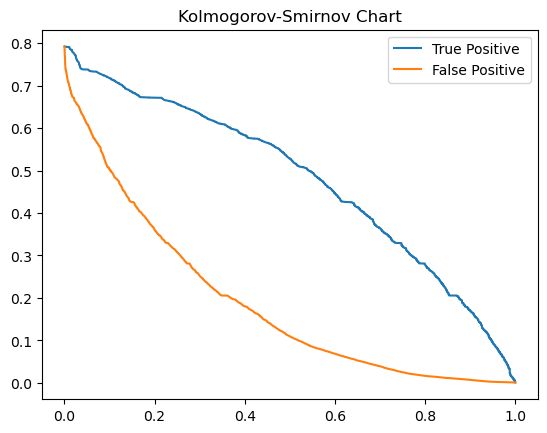

The Kolmogorov-Smirnov Statistic = 0.5244664390313967
The Corresponding probability threshold = 0.2579355595500369
The Misclassification rate for probability threshold 0.2579355595500369 = 0.26493174061433444


In [16]:
outCurve = Regression.curve_coordinates(trainData['Churn_indicator'], 1, 0, outList_FinalModel[6][1])

plt.plot(outCurve['Sensitivity'], outCurve['Threshold'], label = "True Positive")
plt.plot(outCurve['OneMinusSpecificity'], outCurve['Threshold'], label = "False Positive")
plt.xticks()
plt.legend()
plt.title('Kolmogorov-Smirnov Chart')
plt.show()

#Kolmogorov-Smirnov Statistic & corresponding probability threshold
outCurve['Difference'] = outCurve['Sensitivity'] - outCurve['OneMinusSpecificity']
KS = outCurve['Difference'].max()
row = outCurve[outCurve['Difference'] == outCurve['Difference'].max()]
prob_threshold = row['Threshold'].values[0]
print("The Kolmogorov-Smirnov Statistic = " + str(KS))
print("The Corresponding probability threshold = " + str(prob_threshold))

#Misclassification Errorrate for above probability threshold
outSeries_new = Regression.binary_model_metric(trainData['Churn_indicator'], 1, 0, outList_FinalModel[6][1], eventProbThreshold = prob_threshold)
print("The Misclassification rate for probability threshold " + str(prob_threshold) + " = " + str(outSeries_new['MCE']))



<b>(b) Please generate the properly labeled Precision-Recall chart with a No-Skill line.
According to the F1 Score, what is the probability threshold for Churn? What is the misclassification
rate if we use this probability threshold?

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


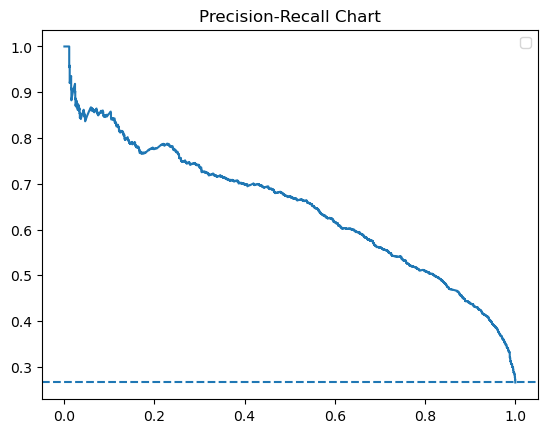

No Skill value = 0.26578498293515357
The F1-Score = 0.6274157303370785
The Corresponding probability threshold = 0.32902080792001154
The Misclassification rate for probability threshold 0.32902080792001154 = 0.23577929465301478


In [17]:
n0 = len(trainData[trainData['Churn_indicator'] == 0])
n1 = len(trainData[trainData['Churn_indicator'] == 1])

no_skill_line = n1/(n0 + n1)
nsl_list = []
recall_line = []
for x in range(len(trainData['Churn_indicator'])):
    nsl_list.append(no_skill_line)
    recall_line.append(1)

plt.plot(outCurve['Recall'], outCurve['Precision'])
plt.axhline(no_skill_line, 0, 1,linestyle="--")
plt.xticks()
plt.legend()
plt.title('Precision-Recall Chart')
plt.show()

#F1-Score & corresponding probability threshold
f1_score = outCurve['F1 Score'].max()
row = outCurve[outCurve['F1 Score'] == outCurve['F1 Score'].max()]
prob_threshold = row['Threshold'].values[0]
print("No Skill value = " + str(no_skill_line))
print("The F1-Score = " + str(f1_score))
print("The Corresponding probability threshold = " + str(prob_threshold))

#Misclassification Errorrate for above probability threshold
outSeries_new = Regression.binary_model_metric(trainData['Churn_indicator'], 1, 0, outList_FinalModel[6][1], eventProbThreshold = prob_threshold)
print("The Misclassification rate for probability threshold " + str(prob_threshold) + " = " + str(outSeries_new['MCE']))
